![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Suitability of satellite sea ice thickness data for assessing climate change

Production date: 30-11-2025

Produced by: Timothy Williams, Nansen Environment and Remote Sensing Center


## 🌍 Use case: Assessing the suitability of the merged CryoSat-2/SMOS satellite sea ice thickness product for estimating sea ice volume

## ❓ Quality assessment question
**How well can sea ice volume be estimated from the Level-4 merged CryoSat-2/SMOS (Soil Moisture and Ocean Salinity) satellite sea ice thickness product?**

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
- With gaps between altimeter tracks (including the polar hole of latitudes exceeding 88$^\circ$N) filled by optimal interpolation (OI) from CryoSat-2 and SMOS (Soil Moisture and Ocean Salinity) measurements ([<span style="color:blue">Ricker et al, 2017</span>](https://doi.org/10.5194/tc-11-1607-2017)), the Level-4 sea ice thickness (SIT) product is well-suited to calculate sea ice volume in the winter months (it is not available in the summer months from May to September due to unresolved bias originating from melting snow or open melt ponds).
- Calculated volumes are similar to reanalysis volumes (see e.g., [<span style="color:blue">Edel et al, 2024</span>](https://doi.org/10.5194/tc-19-731-2025)), and in fact many reanalyses actually assimilate the Level-4 SIT product.
- We find its usefulness is limited for the purpose of studying climate change however, since the available time series (2010-2024) is very short and the sea ice thickness variable has quite a lot of interannual variability.
```

## 📋 Methodology
We consider the [<span style="color:blue">sea ice thickness (SIT) dataset</span>](https://cds.climate.copernicus.eu/datasets/satellite-sea-ice-thickness?tab=overview), which has one Level-4 product, made by using OI to merge CryoSat-2 altimeter data with SMOS passive microwave data.
It dates from October 2010 to present. This dataset also has two Level-3 products based only on altimeter products, which have a lot of missing data making the calculation of sea ice volume from them much more difficult.

To calculate the sea ice volume we also need the SSMIS (Special Sensor Microwave Imager/Sounder) data from the [<span style="color:blue">sea ice concentration (SIC) dataset</span>](https://cds.climate.copernicus.eu/datasets/satellite-sea-ice-concentration?tab=overview). This data was used as auxiliary data for the Level-4 thickness product so the two products are consistent with
each other. These products are both available on the same 25-km equal area grid (the EASE2 (Equal-Area Scalable Earth) grid) so once they have been downloaded, the sea ice volume in one grid cell (in km$^3$) is $V=Ahc$, where $h=$SIT/1000 is the thickness converted from meters to kilometers, $c=$SIC/100 is the sea ice area fraction, and $A=$625 km$^2$ is the grid cell area.
The total sea ice volume can then be found by adding the volumes contained in each grid cell.

A rough estimate of the uncertainty in the volume can be obtained in a similar way, by assuming the SIT and SIC uncertainties are independent, and that spatial errors are uncorrelated between grid cells. The variance in each grid cell is given by $(\Delta V)^2 = A(c\Delta h)^2 + A(h\Delta c)^2$, and the total variance is then obtained by summing over all grid cells.
The standard deviation is then the square root of the total variance.

Time series of the volume and the uncertainties are plotted. The uncertainties estimated in the way described above are quite small in comparison to the total volume, and are likely too low, given the differences between it and independent thickness observations ([<span style="color:blue">Hendricks, 2023</span>](https://dast.copernicus-climate.eu/documents/satellite-sea-ice-thickness/level-4/v1-0/WP2-FDDP-2022-09_C3S2-Lot3_PQAR-of-v1.0-SeaIceThickness-CS2SMOS-product_v1.1_final.pdf)). The uncertainty estimation method is also inconsistent with the application of OI to make the Level-4 product, which used a correlation length scale (not provided with the product) to approximate the spatial correlation ([<span style="color:blue">Hendricks et al, 2023</span>]( https://dast.copernicus-climate.eu/documents/satellite-sea-ice-thickness/level-4/v1-0/WP2-FDDP-2022-09_C3S2-Lot3_ATBD-of-v1.0-SeaIceThickness-CS2SMOS-product_1.1_final.pdf)). A full uncertainty calculation could perhaps be computed with access to the individual Cryosat-2 freeboard data, and passive microwave SMOS and SIC data using a similar method to that used by [<span style="color:blue">Zygmontowska et al (2014)</span>](https://doi.org/10.5194/tc-8-705-2014), who used a Monte Carlo approach to estimate the uncertainty in sea ice volume from Ice-Sat SIT data and SIC data. However, this would be extremely expensive computationally as the OI method would need to be run over many realisations of its input data (altimeter, SMOS, SIC, snow, ice density). [<span style="color:blue">Zygmontowska et al (2014)</span>](https://doi.org/10.5194/tc-8-705-2014) found that uncertainty in snow depth was the biggest contributor uncertainty to the volume uncertainty.

The "Analysis and results" section is structured as follows:

**[](satellite_satellite-sea-ice-thickness_validation_q02:section-1)**
  * Definitions of parameters, download requests and functions.

**[](satellite_satellite-sea-ice-thickness_validation_q02:section-2)**

**[](satellite_satellite-sea-ice-thickness_validation_q02:section-3)**

## 📈 Analysis and results

(satellite_satellite-sea-ice-thickness_validation_q02:section-1)=
### 1. Parameters, requests and functions definition
- Define parameters and formulate requests for downloading with the EQC toolbox.
- Define functions to be applied to process and reduce the size of the downloaded data.
- Define functions to post-process and visualize the data.

#### 1.1 Import libraries
Define code to import the required libraries

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot
import pandas as pd
import numpy as np
import calendar


plt.style.use("seaborn-v0_8-notebook")

# suppress xarray warning
_ = xr.set_options(use_new_combine_kwarg_defaults=True)

#### 1.2 Set parameters
- Set the time range for ENVISAT data with `year_start_envisat` and `year_stop_envisat`
- Set the time range for CRYOSAT data with `year_start_cryosat` and `year_stop_cryosat`

In [2]:
# start and stop for CS2-SMOS
year_start = 2010
year_stop = 2023

# year the SIC dataset changes from CDR to ICDR
sic_icdr_start_year = 2021

#### 1.3 Define function to cache
- `download_siconc_data` downloads the required SIC data to match the time period covered by the SIT data.
- `moving_average` applies a moving average with a window of 7 days to get a mean SIC that matches the time period covered by the SIT data.
- `get_siconc_data` combines the above functions to download, average and format the SIC data into a form that can be used by the `get_sivol` function, which does the volume calculation.

In [3]:
def download_siconc_data(time_bnds):
    """
    Downloads SIC to match the time period covered by the SIT data, determined by its "time_bnds" variable
    
    Parameters
    ----------    
    time_bnds : xarray.DataArray
    """
    start = pd.Timestamp(time_bnds[0,0].values)
    stop = pd.Timestamp(time_bnds[-1,1].values)
    lims = [(start, stop, "cdr" if start.year < sic_icdr_start_year else "icdr")]
    if start.year < sic_icdr_start_year and stop.year >= sic_icdr_start_year:
        lims = [
            (start, pd.Timestamp(sic_icdr_start_year - 1, 12, 31), "cdr"),
            (pd.Timestamp(sic_icdr_start_year, 1, 1), stop, "icdr"),
        ]
    
    collection_id = "satellite-sea-ice-concentration"
    conc_request = {
        "variable": "all",
        "version": "3_0",
        "sensor": "ssmis",
        "region": "northern_hemisphere",
        "temporal_aggregation": "daily",
    }
    requests = []
    for start_, stop_, cdr_type in lims:
        requests += download.update_request_date(
            conc_request | {"cdr_type": cdr_type},
            start = start_,
            stop = stop_,
            stringify_dates=True,
        )

    return download.download_and_transform(collection_id, requests).sel(time=slice(start, stop))


def moving_average(ds):
    """
    Gets 7-day moving average of sea_ice_concentration (mean) and total_standard_uncertainty (rms)
    
    Parameters
    ----------
    ds : xarray.Dataset
    """
    # 7-day moving average for sea_ice_concentration (mean)
    sic_ma = ds['ice_conc'].rolling(time=7, center=True).mean()
    
    # 7-day moving average for total_standard_uncertainty (root mean square)
    tsu_ma = np.sqrt(
        (ds['total_standard_uncertainty'] ** 2).rolling(time=7, center=True).mean()
    )
    
    # Remove NaN time steps (edges from rolling window)
    #valid_times = ~(sic_ma.isnull().all(['yc', 'xc']))
    valid_times = slice(3, -3)

    result = {'ice_conc': sic_ma.isel(time=valid_times),
              'total_standard_uncertainty': tsu_ma.isel(time=valid_times)}
    return xr.Dataset(result)


def get_siconc_data(time_bnds, ds_download=None):
    """
    Parameters
    ----------
    time_bnds : xarray.DataArray
    ds_download : xarray.Dataset
        downloaded SIC data
    """
    if ds_download is None:
        ds_download = download_siconc_data(time_bnds)
    ds = moving_average(ds_download)
    ds["time"].attrs["bounds"] = "time_bnds"
    ds["time_bnds"] = time_bnds
    return ds


def get_sivol(ds, ds_sic=None):
    """
    Calculate sea ice volume and its uncertainty.
    
    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing sea ice thickness and uncertainty fields
    ds_sic:
        Dataset containing sea ice concentration and uncertainty fields (7-day moving average)
        
    Returns
    -------
    xarray.Dataset
        Dataset with sivol (volume) and sivol_uncertainty variables
    """
    # Get ice concentration data
    if ds_sic is None:
        ds_sic = get_siconc_data(ds["time_bnds"])
    
    # Grid resolution in km
    dx = np.diff(ds["xc"].values[:2])[0]
    grid_area = dx ** 2  # km^2
    
    # Extract variables
    sit = ds["sea_ice_thickness"]  # thickness (m)
    sit_unc = ds["uncertainty"]  # thickness uncertainty (m)
    sic = 1e-2 * ds_sic["ice_conc"]  # ice concentration (fraction)
    sic_unc = 1e-2 * ds_sic["total_standard_uncertainty"]  # concentration uncertainty (fraction)
    
    # Calculate volume
    sivol = grid_area * (sic * sit).sum(dim=("xc", "yc")) / 1e3  # km^3
    
    # Uncertainty propagation for product: V = A * sum(C * T)
    # For each grid cell: dV = A * sqrt((C*dT)^2 + (T*dC)^2)
    # Total uncertainty: combine in quadrature across all cells
    
    # Per-cell variance contributions
    var_from_thickness = (sic * sit_unc) ** 2
    var_from_concentration = (sit * sic_unc) ** 2
    
    # Total variance per cell
    total_var_per_cell = var_from_thickness + var_from_concentration
    
    # Sum variances across spatial dimensions (variances add)
    total_variance = total_var_per_cell.sum(dim=("xc", "yc")) #m^2
    
    # Standard uncertainty
    sivol_uncertainty = grid_area * np.sqrt(total_variance) / 1e3 # km^3
    
    # Create output dataset
    result = xr.Dataset({
        "sivol": sivol,
        "sivol_uncertainty": sivol_uncertainty
    })
    
    result["sivol"].attrs["units"] = "km$^3$"
    result["sivol"].attrs["long_name"] = "Sea ice volume"
    result["sivol_uncertainty"].attrs["units"] = "km$^3$"
    result["sivol_uncertainty"].attrs["long_name"] = "Sea ice volume uncertainty"
    result["sivol_uncertainty"].attrs["description"] = (
        "Combined uncertainty from ice concentration and thickness, "
        "propagated assuming independent random errors"
    )
    return result

#### 1.4 Download wrapper functions
- `download_and_get_sivol` downloads the data for one winter and computes the sea ice volume with `get_sivol`, which is then stored on disk.
- `download_examples` downloads example records to plot maps and give a qualitative comparison between the Level-3 and Level-4 products.

In [4]:
def download_and_get_sivol(winter_start_year):
    collection_id = "satellite-sea-ice-thickness"
    request = {
        "processing_level": "level_4",
        "satellite_mission": ["cryosat_2_and_smos_combination"],
        "variable": ["sea_ice_thickness"],
        "temporal_resolution": ["daily"],
        "version": "1_0",     
    }
    start = pd.Timestamp(winter_start_year, 10, 18)
    stop = pd.Timestamp(winter_start_year + 1, 4, 12)
    requests = download.update_request_date(request, start = start, stop = stop, stringify_dates=True)
    ds = download.download_and_transform(collection_id, requests, transform_func=get_sivol)
    return ds.sel(time=slice(start, stop))


def download_examples(year=2020, month=1):

    # calendar info
    years = [str(year)]
    months = [f"{month:02d}"]
    _, ndays = calendar.monthrange(year, month)
    days = [f"{d:02d}" for d in range(1, ndays + 1)]
    
    # download 1 record of CryoSat-2
    collection_id = "satellite-sea-ice-thickness"
    ds = download.download_and_transform(collection_id, {
        "processing_level": "level_3",
        "satellite_mission": ["cryosat_2"],
        "variable": ["sea_ice_thickness"],
        "temporal_resolution": ["monthly"],
        "year": years,
        "month": months,
        "version": "3_0",
    })

    # extract projection variable
    proj_name = "Lambert_Azimuthal_Grid"
    proj_var = xr.DataArray(attrs=ds[proj_name].attrs)

    # set the variables to keep and save their attributes for reassigning later
    varnames = ("sea_ice_thickness", "uncertainty")
    to_drop = [vname for vname in ds.data_vars if vname not in varnames]
    attrs = {vname: ds[vname].attrs for vname in varnames}

    # take mean to remove time dimension and tag as CryoSat-2
    datasets = [ds.drop_vars(to_drop).mean(dim='time').expand_dims(source=["CryoSat-2"])]

    # download 1 month of CS2-SMOS and get the mean of SIT and the RMS uncertainty (averaging over all the days in the month)
    ds = download.download_and_transform(collection_id, {
        "processing_level": "level_4",
        "satellite_mission": ["cryosat_2_and_smos_combination"],
        "variable": ["sea_ice_thickness"],
        "temporal_resolution": ["daily"],
        "year": years,
        "month": months,
        "day": days,
        "version": "1_0"
    }).drop_vars(to_drop)
    data = {
        "sea_ice_thickness": ds["sea_ice_thickness"].mean(dim='time'),
        "uncertainty": np.sqrt((ds["uncertainty"] ** 2).mean(dim='time')),
    }

    # tag as CS2-SMOS
    datasets += [xr.Dataset(data).expand_dims(source=["CS2-SMOS"])]

    # merge datasets
    ds = xr.concat(datasets, 'source')
    del datasets

    # set variable attributes
    for vname, vattrs in attrs.items():
        for attr_name in ("standard_name", "long_name", "units", "grid_mapping"):
            ds[vname].attrs[attr_name] = vattrs[attr_name]
    
    # return after adding the projection variable
    return ds.assign_coords({proj_name: proj_var})

#### 1.5 Plotting functions
- `get_dummy_dataset` adds a dummy date in summer where the volume and its uncertainty are not numbers (`numpy.nan`) so that the plots of consecutive winters are split.
- `plot_time_series` plots times series of the sea ice volume and its uncertainty.

In [5]:
def get_dummy_dataset(ds):
    year = ds.time.dt.year[-1].item()
    data = {var: ('time', [np.nan]) for var in ds.data_vars}
    return xr.Dataset(data).assign_coords({'time': [pd.Timestamp(year, 6, 1)]})


def plot_time_series(ds):
    fig, axs = plt.subplots(2,1, sharex=True, figsize=(14,10))
    ds['sivol'].plot(ax=axs[0])
    ds['sivol_uncertainty'].plot(ax=axs[1])
    for ax in axs:
        _ = ax.set_xlabel('')


def plot_maps(ds_eg, vname, vmax):
    # projection
    proj = ccrs.Stereographic(central_latitude=90)
    # zoom in on variable to plot
    da = ds_eg[vname].isel(xc=slice(90,310), yc=slice(90,310))
    # plot CS2 and CS2-SMOS side-by-side
    facet_grid = plot.projected_map(da, cbar_kwargs={"pad" : .025, 'shrink': .45, 'extend': 'both'}, projection=proj,
            robust=True, col="source", vmax=vmax, show_stats=False, figsize=(12,8))
    facet_grid.set_titles(template="{value}, January 2020")

(satellite_satellite-sea-ice-thickness_validation_q02:section-2)=
### 2. Downloading and transformation of the data
This is where the data is downloaded, transformed into a sea ice volume time series using `get_sivol` and saved to disk by the EQC toolbox. If the code is rerun the transformed data is loaded from the disk.

In [ ]:
datasets = []
for winter_start_year in range(year_start, year_stop + 1):
    print(f"Winter starting in October {winter_start_year}")
    try:
        ds = download_and_get_sivol(winter_start_year)
        #ds = load_local_files_and_get_sivol(winter_start_year, force=False)
    except:
        print(f"Could not get sivol for {winter_start_year}")
        continue
    dummy = [] if len(datasets) == 0 else [get_dummy_dataset(ds)]
    datasets += dummy + [ds]
ds_vol = xr.concat(datasets, 'time')
del datasets

In [ ]:
ds_eg = download_examples()

(satellite_satellite-sea-ice-thickness_validation_q02:section-3)=
### 3. Results
- We plot monthly maps showing the mean and variability for the two satellites, and also plot the difference between the means for the two satellites to get an idea of the change in thickness going from the earlier to the later period.
- We compute linear trends for the two satellites and test the goodness-of-fit of the linear fit.

#### 3.1 Qualitative comparison of Level-3 and Level-4 products

Below we show the mean SIT for the Level-3 product using only CryoSat-2 data and the Level-4 product which merges CryoSat-2 and SMOS data. The SIT are similar in the areas with thicker ice (when the altimeter is more reliable), but gaps have been filled in the Level-4 product by the optimal interpolation (OI). The OI has also made the SIT much smoother.

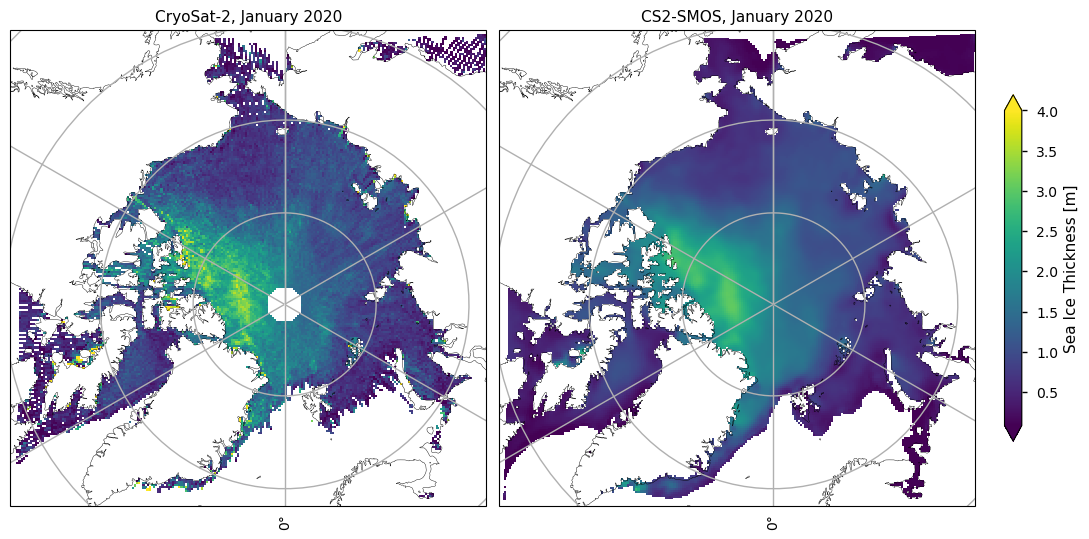

In [8]:
plot_maps(ds_eg, "sea_ice_thickness", 4)

Below we show the uncertainty in SIT for the Level-3 product and the RMS uncertainty Level-4 product which merges CryoSat-2 and SMOS data. The OI, which partly aims to minimise uncertainty, has approximately halved the uncertainty of the Level-4 product compared to the Level-3 product.

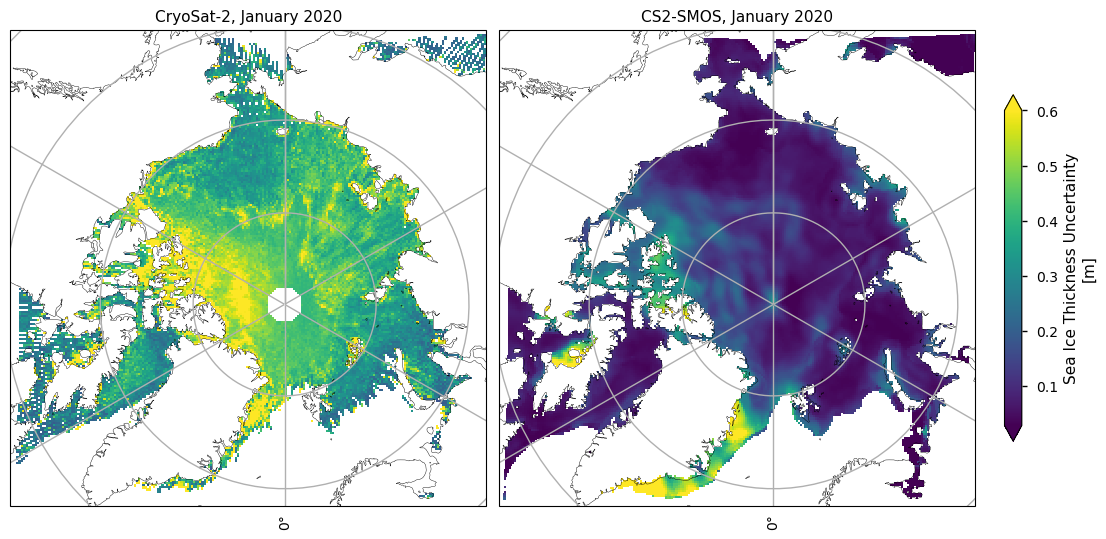

In [9]:
plot_maps(ds_eg, "uncertainty", .6)

Below we plot the standard deviations of the two satellite periods. Looking at the CryoSat-2 plots, the variability is roughly correlated with thickness, but there is also high variability in the Greenland Sea due to the highly dynamic nature of that area (the ice flows quite fast once it is exported through the Fram Strait).

Below we plot the difference between the means of the two satellite periods. The two satellites have different biases (CryoSat-2 has a slight positive bias, while ENVISAT has a more significant negative bias) and accuracies so we should be be a little careful when comparing and trying to deduce temporal changes between them. In general the mean thickness has dropped, with the exception of the area north of the Canadian archipelago and in the Greenland Sea in the later winter months. Given the satellite biases we can trust the reductions in thickness more than the increases in thickness. Moreover the increases in thickness also occur in regions of higher variability. Having said this we have used an 8-10 year averaging period so hopefully some of the variability will have been smoothed out.

#### 3.2 Time series of sea ice volume and its uncertainty

Below we plot the time series of the sea ice volume and its uncertainty as derived from the Level-4 product. Due to there only having been 13 winters since CryoSat-2 started measuring data, it is difficult to see any trend in the volume or the net increase over each winter. Some model-based (including the commonly-used reference reanalysis PIOMAS ([<span style="color:blue">Pan-Arctic Ice Ocean Modeling and Assimilation System</span>](https://psc.apl.uw.edu/research/projects/arctic-sea-ice-volume-anomaly/)) and a machine learning model) time series (see e.g., [<span style="color:blue">Edel et al, 2024</span>](https://doi.org/10.5194/tc-19-731-2025)) show a drop in volume over longer time series (1991-2020), with similar volumes in the 2010-2020 period to the plot below.
Note that some of the models in the paper of [<span style="color:blue">Edel et al (2024)</span>](https://doi.org/10.5194/tc-19-731-2025) either assimilate CS2-SMOS data or use the innovations from assimilating it to correct biases in years before it became available. [<span style="color:blue">Soriot et al (2024)</span>](https://doi.org/10.1038/s41598-024-70136-9) also trained a machine learning model with LIDAR (Light Detection And Ranging) altimetry data to produce sea ice thickness from passive microwave data, giving a SIT time series covering 1992-2020. While giving a greater volume than PIOMAS it had similar downward trends and interannual variability.

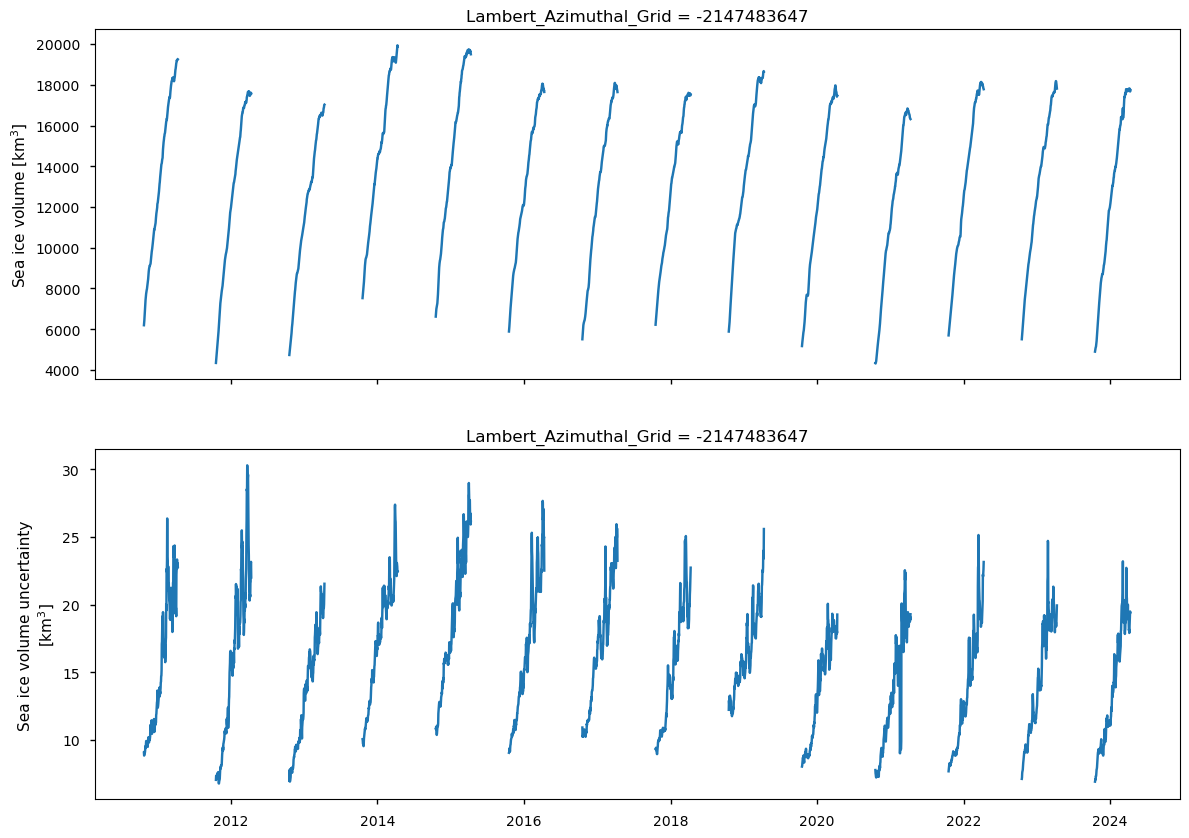

In [10]:
plot_time_series(ds_vol)

## ℹ️ If you want to know more

### Key resources

Introductory sea ice materials:
- [<span style="color:blue">Role of sea ice in the climate</span>](https://www.epa.gov/climate-indicators/climate-change-indicators-arctic-sea-ice)
- [<span style="color:blue">Observing sea ice with satellites</span>](https://www.metoffice.gov.uk/research/climate/cryosphere-oceans/sea-ice/measure)

Code libraries used:
* [<span style="color:blue">C3S EQC custom functions</span>](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/).

### References

[1] Ricker, R., Hendricks, S., Kaleschke, L., Tian-Kunze, X., King, J., & Haas, C. (2017). A weekly Arctic sea-ice thickness data record from merged CryoSat-2 and SMOS satellite data. The Cryosphere, 11(4), 1607-1623, <span style="color:blue"> https://doi.org/10.5194/tc-11-1607-2017 </span>

[2] Hendricks, S., Ricker, R., Kaleschke, L., Tian-Kunze, X. (2023) Sea Ice Thickness - CryoSat-2/SMOS Version 1.0: Algorithm Theoretical Basis Document. Copernicus Climate Change Service, Document reference: WP2-FDDP-2022-09_C3S2-Lot3_ATBD-of-v1.0-SeaIceThickness-CS2SMOS-product_v1.1, <span style="color:blue"> https://dast.copernicus-climate.eu/documents/satellite-sea-ice-thickness/level-4/v1-0/WP2-FDDP-2022-09_C3S2-Lot3_ATBD-of-v1.0-SeaIceThickness-CS2SMOS-product_1.1_final.pdf </span>

[3] Hendricks, S. (2023). Sea Ice Thickness – CryoSat2-2/SMOS, Version 1.0: Product Quality Assessment Report. Copernicus Climate Change Service, Document reference: WP2-FDDP-2022-09_C3S2-Lot3_PQAR-of-v1.0-SeaIceThickness-CS2SMOS-products_v1.1, <span style="color:blue"> https://dast.copernicus-climate.eu/documents/satellite-sea-ice-thickness/level-4/v1-0/WP2-FDDP-2022-09_C3S2-Lot3_PQAR-of-v1.0-SeaIceThickness-CS2SMOS-product_v1.1_final.pdf </span>

[4] Zygmuntowska, M., Rampal, P., Ivanova, N., & Smedsrud, L. H. (2014). Uncertainties in Arctic sea ice thickness and volume: new estimates and implications for trends. The Cryosphere, 8(2), 705-720, <span style="color:blue"> https://doi.org/10.5194/tc-8-705-2014 </span>

[5] Edel, L., Xie, J., Korosov, A., Brajard, J., & Bertino, L. (2025). Reconstruction of Arctic sea ice thickness (1992–2010) based on a hybrid machine learning and data assimilation approach. The Cryosphere, 19(2), 731-752, <span style="color:blue"> https://doi.org/10.5194/tc-19-731-2025 </span>

[6] Soriot, C., Vancoppenolle, M., Prigent, C., Jimenez, C., & Frappart, F. (2024). Winter arctic sea ice volume decline: uncertainties reduced using passive microwave-based sea ice thickness. Scientific Reports, 14(1), 21000, <span style="color:blue"> https://doi.org/10.1038/s41598-024-70136-9 </span>